# Explainability with SageMaker Clarify using AWS SDK for Python (Boto3) - Configuring Features to Explain

## Contents

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Import libraries](#Import-libraries)
    1. [Set configurations](#Set-configurations)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Encode and Upload the Dataset](#Encode-and-Upload-the-Dataset) 
1. [Train and Deploy XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Create Model](#Create-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Set Configurations](#Set-Configurations)
    1. [Get Started with a SageMaker Clarify Container](#Get-Started-with-a-SageMaker-Clarify-Container)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Configure a SageMaker Clarify Processing Job Container's Input and Output Parameters ](#Configure-a-SageMaker-Clarify-Processing-Job-Container's-input-and-output-parameters)
        1. [Configure Analysis Config](#Configure-analysis-config)
        1. [Run SageMaker Clarify Processing Job](#Run-SageMaker-Clarify-Processing-job)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
        1. [Analysis of local explanations](#Analysis-of-local-explanations)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker Clarify can help improve your machine learning models by helping explain how these models make predictions. Specifically, Clarify uses Kernel SHAP to explain the contribution that each model feature makes to the final prediction. Customers also have the option to specify specific model features they would like to be explained for tabular data. 

This sample notebook walks you through:  
1. Key terms and concepts needed to understand SageMaker Clarify
1. Explaining the importance of the various input features on the model's decision and configuring features to explain.
1. Accessing the reports through SageMaker Studio if you have an instance set up.

In doing so, the notebook first trains a [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model using training dataset, then utilizes the [AWS SDK for Python](https://aws.amazon.com/sdk-for-python/) to launch SageMaker Clarify jobs to analyze an example dataset in CSV format. Additionally, there are peer examples available that use the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) to launch SageMaker Clarify jobs to analyze data [in CSV format](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability.ipynb) and [in JSON Lines format](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability_jsonlines_format.ipynb).

## Prerequisites and Data

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import boto3
import time
from datetime import datetime
from sagemaker import get_execution_role, session

### Set configurations

In [3]:
# Initialize sagemaker session
sagemaker_session = session.Session()

region = sagemaker_session.boto_region_name
print(f"Region: {region}")

role = get_execution_role()
print(f"Role: {role}")

bucket = sagemaker_session.default_bucket()

prefix = "sagemaker/DEMO-sagemaker-clarify-boto3"

Region: us-west-2
Role: arn:aws:iam::786499417150:role/service-role/AmazonSageMaker-ExecutionRole-20221010T162799


### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [4]:
from sagemaker.s3 import S3Downloader

adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data"
        ),
        local_path="./",
        sagemaker_session=sagemaker_session,
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.test"
        ),
        local_path="./",
        sagemaker_session=sagemaker_session,
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data saved!
adult.test saved!


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:

1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task: 

15. **Target**: <=50,000, >$50,000.

In [5]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

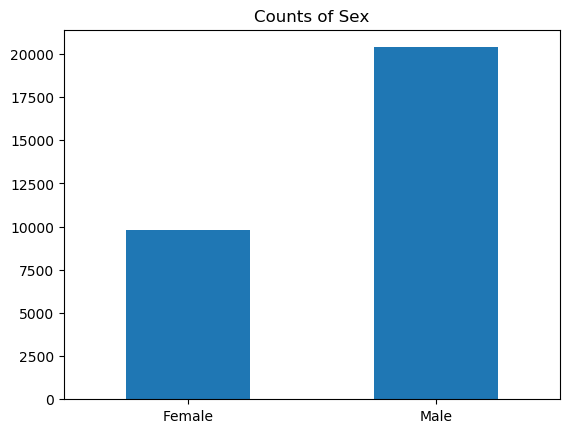

In [6]:
%matplotlib inline
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

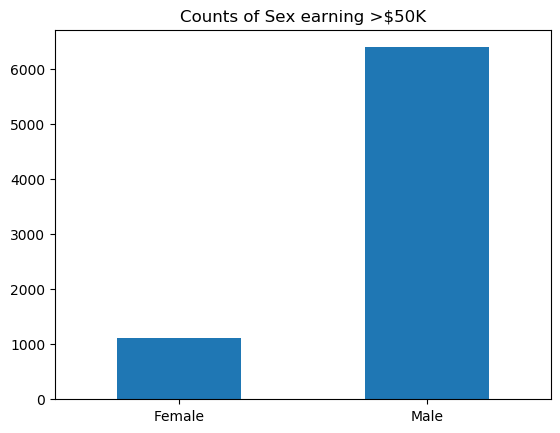

In [7]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Encode and Upload the Dataset
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [8]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [9]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


Lastly, let's upload the data to S3.

In [10]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload(
    local_path="train_data.csv",
    desired_s3_uri="s3://{}/{}".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
)
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload(
    local_path="test_features.csv",
    desired_s3_uri="s3://{}/{}".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
)

### Train XGBoost Model
#### Train Model
Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model. For this section we will be using Amazon SageMaker Python SDK for simplicity.

It takes about 5 minutes for the model to be trained.

In [11]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

# This is references the AWS managed XGBoost container
xgboost_image_uri = retrieve(region=region, framework="xgboost", version="1.5-1")

xgb = Estimator(
    xgboost_image_uri,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=sagemaker_session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-13-05-48-24-982



2023-06-13 05:48:25 Starting - Starting the training job.
2023-06-13 05:48:40 Starting - Preparing the instances for training..........
2023-06-13 05:49:35 Downloading - Downloading input data....
2023-06-13 05:50:00 Training - Downloading the training image....
2023-06-13 05:50:25 Training - Training image download completed. Training in progress.......
2023-06-13 05:51:01 Uploading - Uploading generated training model..
2023-06-13 05:51:12 Completed - Training job completed


#### Create Model
Here we create the SageMaker model.

In [12]:
model_name = "DEMO-clarify-xgboost-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: DEMO-clarify-xgboost-model


'DEMO-clarify-xgboost-model'

## Amazon SageMaker Clarify
With your model set up, it's time to explore SageMaker Clarify. For a general overview of how SageMaker Clarify processing jobs work, refer to [the provided link](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-configure-how-it-works.html). This section will demonstrate how to use the AWS SDK for Python (Boto3) to launch SageMaker Clarify processing jobs.

### Set Configurations

In [13]:
# Initialise SageMaker boto3 client
sagemaker_client = boto3.Session().client("sagemaker")

# Note: We will be using role fetched in section 1 for convenient/demo purpose so that the notebook
# can be easily executed in SageMaker Studio or SageMaker Notebook Instance.
# You can use their own execution role for their project.
print(f"Role: {role}")

print(f"Region: {region}")

Role: arn:aws:iam::786499417150:role/service-role/AmazonSageMaker-ExecutionRole-20221010T162799
Region: us-west-2


### Get Started with a SageMaker Clarify Container
Amazon SageMaker provides prebuilt SageMaker Clarify container images that include the libraries and other dependencies needed to compute bias metrics and feature attributions for explainability. This image has been enabled to run SageMaker Clarify processing job in your account.

The following code uses the SageMaker Python SDK API to easily retrieve the image URI. If you are unable to use the SageMaker Python SDK, you can find the image URI by referring to [the regional image URI page](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-configure-container.html).

In [14]:
clarify_image_uri = retrieve(region=region, framework="clarify", version="1.0")
print(f"Clarify Image URI: {clarify_image_uri}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Clarify Image URI: 306415355426.dkr.ecr.us-west-2.amazonaws.com/sagemaker-clarify-processing:1.0


In [21]:
def create_processing_job(analysis_config_path, analysis_result_path):
    processing_job_name = "DEMO-clarify-job-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

    response = sagemaker_client.create_processing_job(
        ProcessingJobName=processing_job_name,
        AppSpecification={"ImageUri": clarify_image_uri},
        ProcessingInputs=[
            {
                "InputName": "analysis_config",
                "S3Input": {
                    "S3DataType": "S3Prefix",
                    "S3InputMode": "File",
                    "S3Uri": analysis_config_path,
                    "LocalPath": "/opt/ml/processing/input/config",
                },
            },
            {
                "InputName": "dataset",
                "S3Input": {
                    "S3DataType": "S3Prefix",
                    "S3InputMode": "File",
                    "S3Uri": train_uri,
                    "LocalPath": "/opt/ml/processing/input/data",
                },
            },
        ],
        ProcessingOutputConfig={
            "Outputs": [
                {
                    "OutputName": "analysis_result",
                    "S3Output": {
                        "S3Uri": analysis_result_path,
                        "LocalPath": "/opt/ml/processing/output",
                        "S3UploadMode": "EndOfJob",
                    },
                }
            ]
        },
        ProcessingResources={
            "ClusterConfig": {
                "InstanceCount": 1,
                "InstanceType": "ml.m5.xlarge",
                "VolumeSizeInGB": 30,
            }
        },
        StoppingCondition={
            "MaxRuntimeInSeconds": 3600,
        },
        RoleArn=role,
    )

    return processing_job_name

Here is a brief explanation of inputs used above, for detailed documentation check [CreateProcessingJob API reference](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateProcessingJob.html):

* `AppSpecification`: Here we provide the region specific clarify image uri we fetched earlier
* `ProcessingInputs`: Clarify job requires that you provide two ProcessingInput parameters.
  * `InputName: analysis_config`: The analysis configuration JSON file for a SageMaker Clarify job must be specified as an Amazon S3 object with the InputName "analysis_config". We will be providing the example analysis_configs that we have provided with this notebook. 
  * `InputName: dataset`, dataset fetched earlier provided here as an Amazon S3 object.
* `ProcessingOutputConfig`: The job also requires an output parameter, the output location as an Amazon S3 prefix with the OutputName "analysis_result". The S3UploadMode should be set to "EndOfJob", because the analysis results is generated at the end of the job. We will be providing here the `analysis_result_path` that we configured earlier.
* `ProcessingResources` contains the ClusterConfig specifying the ML compute instance type we want to use and the count. SageMaker SHAP analysis is CPU-intensive, to speed up the analysis, use a better instance type, or add more instances to enable Spark parallelization. The SageMaker Clarify job doesn’t use GPU.
* `StoppingCondition`: Using a maximum limit of 60 min for example job run. You can set the MaxRuntimeInSeconds of a SageMaker Clarify job to up to 7 days (604800 seconds). If the job cannot be completed within this time limit, it will be force-stopped and no analysis results are provided.

In [22]:
# Wait for processing job to complete
def wait_for_job(job_name):
    while (
        sagemaker_client.describe_processing_job(ProcessingJobName=job_name)["ProcessingJobStatus"]
        == "InProgress"
    ):
        print(".", end="")
        time.sleep(60)
    print()

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses Kernel SHAP to explain the contribution that each input feature makes to the final decision.

#### Configure a SageMaker Clarify Processing Job Container's input and output parameters 

In [24]:
explainability_analysis_config_path = "s3://{}/{}/explainability_analysis_config.json".format(
    bucket, prefix
)
explainability_analysis_result_path = "s3://{}/{}/explainability_analysis_output".format(
    bucket, prefix
)

#### Configure analysis config
For our example use case we will be using the following analysis config. 

Note that if you do not wish for all model features to be explained by Kernel SHAP, you can configure the `features_to_explain` parameter as a list of feature names or indices to specify the model features you would like explanations computed for as seen below:

In [26]:
!echo
!cat explainability_analysis_config.json


{
    "dataset_type": "text/csv",
    "headers": ["Target", "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status", "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss", "Hours per week", "Country"],
    "label": "Target",
    "methods": {
        "shap": {
            "baseline": [
                [38, 2, 189794, 10, 10, 3, 6, 1, 4, 1, 1092, 88, 41, 36]
            ],
            "num_samples": 15,
            "agg_method": "mean_abs",
            "use_logit": false,
            "save_local_shap_values": true,
            "features_to_explain": ["Age", "Education", "Occupation"]
        },
        "report": {
            "name": "report",
            "title": "Analysis Report"
        }
    },
    "predictor": {
        "model_name": "DEMO-clarify-xgboost-model",
        "instance_type": "ml.m5.xlarge",
        "initial_instance_count": 1,
        "accept_type": "text/csv",
        "content_type": "text/csv"
    }
}

`explainability_analysis_config.json` here contains configuration values for computing feature attribution using a SageMaker Clarify job:

* `dataset_type` specify the format of your dataset, for this example as we are using csv dataset this will be `text/csv`
* `headers` is the list of column names in the dataset
* `label` specifies the ground truth label, in this example the "Target" column. The SageMaker Clarify job will drop the column and uses the remaining feature columns for explainability analysis.
* `methods` is the list of methods and their parameters for the analyses and reports.
  * `shap:` This section has the parameter for SHAP analysis. 
      * `baseline`: Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as `dataset_type`, and baseline samples shall only include features. By definition, `baseline` should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the mean of the train dataset to the list. For more details on baseline selection please [refer this documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).
      * `features_to_explain`: 
* `predictor` includes model configuration, this section is required if the analysis requires predictions from model
  * `model_name`: name of the concerned model, using name of the xgboost model trained earlier, `DEMO-clarify-xgboost-model`
  * `instance_type` and `initial_instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify's processing. The testing dataset is small, so a single standard instance is good enough to run this example.
  * `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint. As per the example model we created above both of these will be `text/csv`

In [27]:
# Upload the analysis_config to the concerned S3 path.
S3Uploader.upload(
    "explainability_analysis_config.json", "s3://{}/{}".format(bucket, prefix)
)

's3://sagemaker-us-west-2-786499417150/sagemaker/DEMO-sagemaker-clarify-boto3/explainability_analysis_config.json'

#### Run SageMaker Clarify Processing job

In [28]:
# The job takes about 10 minutes to run
processing_job_name = create_processing_job(
    explainability_analysis_config_path, explainability_analysis_result_path
)
wait_for_job(processing_job_name)

................


#### Viewing the Explainability Report
As with the bias report, you can view the explainability report in Studio under the experiments tab.


<img src="images/explainability_trial_component.png">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, you can access the complete analysis report at the following S3 bucket.

In [35]:
explainability_analysis_result_path

's3://sagemaker-us-west-2-786499417150/sagemaker/DEMO-sagemaker-clarify-boto3/explainability_analysis_output'

#### Analysis of local explanations
It is possible to visualize the local explanations for single examples in your dataset. You can use the obtained results from running Kernel SHAP algorithm for global explanations.

You can simply load the local explanations stored in your output path, and visualize the explanation (i.e., the impact that the single features have on the prediction of your model) for any single example.

Example number: 111 
with model prediction: False

Feature values -- Label Target                 0
Age                   21
Workclass              2
fnlwgt            199915
Education             15
Education-Num         10
Marital Status         4
Occupation             7
Relationship           3
Ethnic group           4
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per week        40
Country               38
Name: 120, dtype: int64


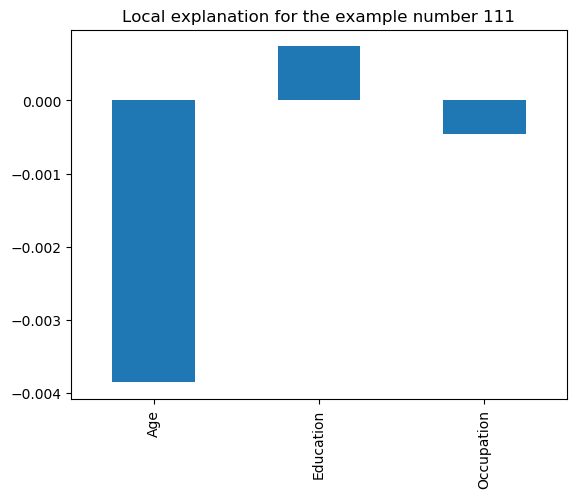

In [36]:
local_explanations_out = pd.read_csv("out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [27]:
sagemaker_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': '00748684-073e-4201-8186-f9603a8ebe3b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '00748684-073e-4201-8186-f9603a8ebe3b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 19 Jan 2023 01:29:06 GMT'},
  'RetryAttempts': 0}}